# Download data

In [1]:
!wget -nc 140.114.76.113:8000/ccpd6000.zip
!unzip -nq ccpd6000.zip
!ls -alh

--2019-12-06 13:33:31--  http://140.114.76.113:8000/ccpd6000.zip
Connecting to 140.114.76.113:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332013713 (317M) [application/zip]
Saving to: ‘ccpd6000.zip’

ccpd6000.zip        100%[===================>] 316.63M  7.26MB/s    in 46s     

2019-12-06 13:34:49 (6.81 MB/s) - ‘ccpd6000.zip’ saved [332013713/332013713]

total 317M
drwxr-xr-x 1 root root 4.0K Dec  6 13:34 .
drwxr-xr-x 1 root root 4.0K Dec  6 13:30 ..
drwxr-xr-x 4 root root 4.0K Nov 19 11:35 ccpd6000
-rw-r--r-- 1 root root 317M Nov 19 11:44 ccpd6000.zip
drwxr-xr-x 1 root root 4.0K Nov 27 22:38 .config
drwxr-xr-x 1 root root 4.0K Nov 27 22:38 sample_data


In [2]:
!sha256sum ccpd6000.zip

977d7124a53e565c3f2b371a871ee04ebbe572f07deb0b38c5548ddaae0cb2c9  ccpd6000.zip


## Init and Utility

In [0]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as tf
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = Path('./ccpd6000/') # the root directory of the dataset

In [0]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

## Training Data

3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


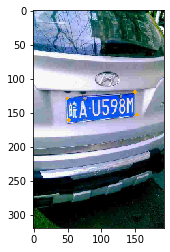

In [5]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)
        self.img_paths = self.img_dir.glob('*.jpg')
        self.img_paths = sorted(list(self.img_paths))

    def __len__(self):
        '''Return the number of sample'''
        return len(self.img_paths)
        #raise NotImplementedError()

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of 
                bottom-right, bottom-left, top-left, top-right corners. 
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''

        img_path = self.img_paths[idx]
    
        # load image
        img = Image.open(img_path)
        W, H = img.size
        #print(W)
        #print(H)
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)
        
        # parse annotation
        #print(self.anns[idx])
        annotations = self.anns[idx]
        kpt = [float(annotations[field]) for field in FIELDS]
        kpt = torch.tensor(kpt)
        kpt = kpt.view(4, 2)
        kpt = kpt / torch.FloatTensor([W, H])
        kpt = kpt.view(-1)
        
        return img, kpt

        #raise NotImplementedError()

# Do some checking and visualization
data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
print(len(data))    # should be 3000

img, kpt = data[-1] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

## Network

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((4, 4)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
        )
        self.regression = nn.Sequential(
            nn.Flatten(), nn.Linear(480, 32), nn.ReLU(), nn.Linear(32, 8), nn.Sigmoid()
        )

    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and 
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            kpt_b: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''

        N = img_b.size(0)
        kpt_b = self.features(img_b)
        kpt_b = kpt_b.view(N, -1)
        kpt_b = self.regression(kpt_b)
        return kpt_b

        #raise NotImplementedError()


# Do some checking
loader = DataLoader(data, batch_size=10) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]

# Do a forwarding
device = 'cuda'     # the computing device, 'cuda' or 'cpu'
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
loss = criterion(pred_b, kpt_b)
print(loss)

torch.Size([10, 3, 320, 192])
torch.Size([10, 8])
tensor(0.1244, device='cuda:0', grad_fn=<L1LossBackward>)


## Training

In [7]:
class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Construct visualization data (25 training samples, 25 validation samples)
        # 3. Make the corresponding dataloaders
        data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))
        self.visul_set = ConcatDataset(
            [
                Subset(self.train_set, random.sample(range(len(self.train_set)), k=25)),
                Subset(self.valid_set, random.sample(range(len(self.valid_set)), k=25)),
            ]
        )
        self.train_loader = DataLoader(self.train_set, 10, shuffle=True, num_workers=4)
        self.valid_loader = DataLoader(self.valid_set, 10, shuffle=False, num_workers=4)
        self.visul_loader = DataLoader(self.visul_set, 10, shuffle=False)

        # model, loss function, optimizer
        self.device = 'cuda'
        self.model = Net().to(self.device)
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.1)
        self.max_epoch = 20
        self.history = {
            'train_mae': [],
            'train_mse': [],
            'valid_mae': [],
            'valid_mse': []
        }

    def run(self):
        metrics = {'train_loss': [], 'valid_loss': []}
        for self.epoch in range(self.max_epoch): # 5 epochs
            train_loss = self.train() # train 1 epoch
            self.scheduler.step()
            valid_loss = self.valid() # valid 1 epoch
            self.visul()              # visualization

            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)

            # Save the parameters(weights) of the model to disk
            if torch.tensor(self.history['valid_mae']).argmin() == self.epoch:
                torch.save(self.model.state_dict(), str(self.log_dir / 'model.pth'))
            #raise NotImplementedError()

        # Plot the loss curve against epoch
        self.log(self.epoch)
        #raise NotImplementedError()

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''

        self.model.train()
        mae_steps = []
        #mse_steps = []

        for img_b, kpt_b in iter(self.train_loader):
            img_b = img_b.to(device)
            kpt_b = kpt_b.to(device)

            self.optimizer.zero_grad()
            pred_b = self.model(img_b)
            loss = self.criterion(pred_b, kpt_b)
            loss.backward()
            self.optimizer.step()
            mae = loss.detach().item()
            #mse = F.mse_loss(pred_b.detach(), kpt_b.detach()).item()
            mae_steps.append(mae)
            #mse_steps.append(mse)
          
        avg_mae = sum(mae_steps) / len(mae_steps)
        #avg_mse = sum(mse_steps) / len(mse_steps)
        self.history['train_mae'].append(avg_mae)
        #self.history['train_mse'].append(avg_mse)

        return avg_mae

        #raise NotImplementedError()

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''

        self.model.eval()
        mae_steps = []
        #mse_steps = []

        for img_b, kpt_b in iter(self.valid_loader):
            img_b = img_b.to(device)
            kpt_b = kpt_b.to(device)
            pred_b = self.model(img_b)
            loss = self.criterion(pred_b, kpt_b)
            mae = loss.detach().item()
            #mse = F.mse_loss(pred_b.detach(), kpt_b.detach()).item()
            mae_steps.append(mae)
            #mse_steps.append(mse)

        avg_mae = sum(mae_steps) / len(mae_steps)
        #avg_mse = sum(mse_steps) / len(mse_steps)
        self.history['valid_mae'].append(avg_mae)
        #self.history['valid_mse'].append(avg_mse)

        return avg_mae

        #raise NotImplementedError()

    @torch.no_grad()
    def visul(self):
        ''' Visualize some samples
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do:
            a. forward to get predictions
            b. visualize and save visualization to log_dir / f'{epoch:03d}'
        As a result, first 25 samples are from training data and last 25 samples are from validation.
        '''
        self.model.eval()
        epoch_dir = self.log_dir / f'{self.epoch:03d}'
        epoch_dir.mkdir(parents=True)
        idx = 0
        for img_b, kpt_b in iter(self.visul_loader):
            pred_b = self.model(img_b.to(self.device)).to('cpu')
            for img, kpt, pred in zip(img_b, kpt_b, pred_b):
                img = tf.to_pil_image(img)
                vis = draw_kpts(img, kpt, c='orange')
                vis = draw_kpts(img, pred, c='red')
                vis.save(epoch_dir / f'{idx:03d}.jpg')
                idx += 1

    def log(self,epoch):
        fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
        ax.set_title('MAE')
        ax.plot(range(epoch + 1), self.history['train_mae'], label='Train')
        ax.plot(range(epoch + 1), self.history['valid_mae'], label='Valid')
        ax.legend()
        fig.savefig(str(self.log_dir / 'metrics.png'))
        plt.close()


log_dir = Path('./runs/') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir.mkdir(parents=True)
Trainer(log_dir).run()

Epoch 000:
train loss: 0.030282978624260673
valid loss: 0.02172690033912659
Epoch 001:
train loss: 0.015947305504232644
valid loss: 0.016742958904554447
Epoch 002:
train loss: 0.014051990199368447
valid loss: 0.012217139530306061
Epoch 003:
train loss: 0.01198880616769505
valid loss: 0.010140802742292484
Epoch 004:
train loss: 0.011589462967822328
valid loss: 0.012531162410353621
Epoch 005:
train loss: 0.011332731920992956
valid loss: 0.011053508411472042
Epoch 006:
train loss: 0.010415905194046596
valid loss: 0.01231361685010294
Epoch 007:
train loss: 0.010106251895194873
valid loss: 0.010681722196750343
Epoch 008:
train loss: 0.009766414530652886
valid loss: 0.009367427323013544
Epoch 009:
train loss: 0.009516573782699803
valid loss: 0.009861016785725952
Epoch 010:
train loss: 0.007263198886842777
valid loss: 0.007749659079127014
Epoch 011:
train loss: 0.006931619846727699
valid loss: 0.007736575634529193
Epoch 012:
train loss: 0.006777897399539749
valid loss: 0.007607783299560348
Ep

## Testing

In [8]:
# Do testing

from pathlib import Path
from datetime import datetime
import pandas as pd
from tqdm import tqdm
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as tf
import os

class CCPDTest:
    def __init__(self, img_dir, img_size):
        img_paths = Path(img_dir).glob('*.jpg')
        self.img_paths = sorted(list(img_paths))
        self.img_size = img_size

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize(self.img_size)
        img = tf.to_tensor(img)
        return img


test_set = CCPDTest('ccpd6000/test_images/', (192,320))
print(len(test_set))
test_loader = DataLoader(test_set, 32, shuffle=False, num_workers=2)

#print(log_dir)

device = 'cuda'
model = Net().to(device)
model.load_state_dict(torch.load(str(log_dir / 'model.pth')))
model.eval()

test_log_dir = Path('./test/')
if not os.path.exists(test_log_dir):
  test_log_dir.mkdir(parents=True)
print(test_log_dir)

def test(pbar):
    anns = []
    for img_b in iter(test_loader):
        kpt_b = model(img_b.to(device)).cpu()

        for img, kpt in zip(img_b, kpt_b):
            img = tf.to_pil_image(img)
            #vis = draw_kpts(img, kpt, c='red')
            #vis.save(test_log_dir / f'{pbar.n:04d}_vis.jpg')
            kpt = torch.tensor(kpt)
            kpt = kpt.view(4, 2)
            kpt = kpt * torch.FloatTensor([720, 1160])
            kpt = kpt.view(-1)
            '''
            kpt = torch.tensor(kpt)
            kpt = kpt.view(4, 2) 
            kpt = kpt / torch.FloatTensor([W, H])
            kpt = kpt.view(-1) 
            '''

            anns.append([f'{pbar.n:04d}.jpg', *kpt.numpy().tolist()])
            pbar.update()
    #print(anns)        
    return pd.DataFrame(anns)


with torch.no_grad():
    with tqdm(total=len(test_set)) as pbar:
        df_pred = test(pbar)
    df_pred.columns = ['name', 'BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y']
    df_pred.to_csv(test_log_dir / 'test_pred.csv', float_format='%.5f', index=False)

#raise NotImplementedError()

  0%|          | 0/3000 [00:00<?, ?it/s]

3000
test


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 3000/3000 [00:41<00:00, 72.47it/s]


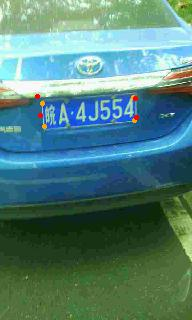

In [9]:
display.Image(str(log_dir / '004' / '001.jpg')) # A visualization of training data in epoch 4

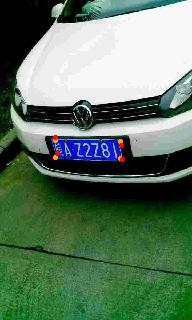

In [10]:
display.Image(str(log_dir / '004' / '025.jpg')) # A visualization of validation data in epoch 4

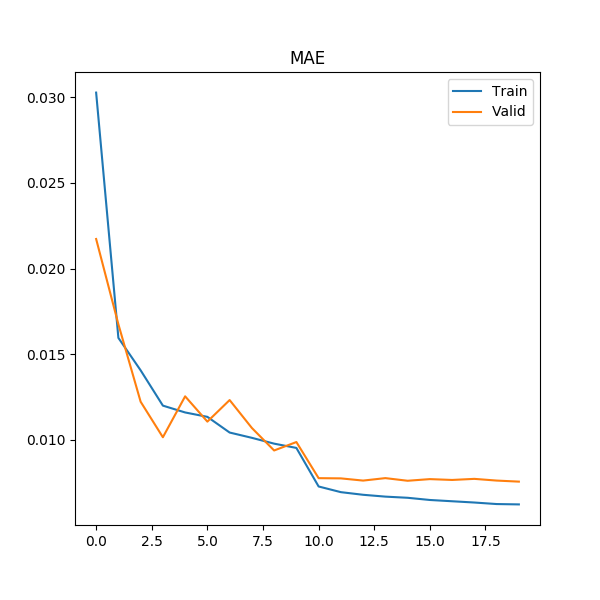

In [11]:
display.Image(str(log_dir / 'metrics.png')) # Loss

In [12]:
!curl -F "file=@./test/test_pred.csv" -X POST 140.114.76.113:5000/cs6550 -i

HTTP/1.1 100 Continue

HTTP/1.0 200 OK
Content-Type: application/json
Content-Length: 16
Server: Werkzeug/0.16.0 Python/3.7.5
Date: Fri, 06 Dec 2019 13:49:17 GMT

{"rmse":13.225}
